## Config

In [1]:
import numpy as np
import random
import math

## Rewards and Policies

### Rewards

In [2]:
def create_reward_function(num_actions, means, variances):

    if len(means) != num_actions or len(variances) != num_actions:
        raise ValueError("Length of means and variances should be equal to num_actions.")

    def reward_function(action):
        action -= 1

        if action < 0 or action >= num_actions:
            raise ValueError("Invalid action index.")

        return np.random.normal(means[action], variances[action])

    return reward_function

### Policies

Random:

In [3]:
def random_bandit_policy(num_actions):
    actions = range(1, num_actions + 1)
    action = random.choice(actions)

    return action

Epsilon greedy:

In [4]:
def epsilon_greedy_policy(q_values, epsilon):
    num_actions = len(q_values)

    if np.random.rand() < epsilon:
        action = np.random.choice(num_actions)  # Explore
    else:
        action = np.argmax(q_values)  # Exploit (pick the action with the highest Q-value)

    action += 1

    return action

UCB:

In [5]:
def ucb_policy(q_values, action_counts, total_steps, c=2):
    num_actions = len(q_values)
    ucb_values = [0] * num_actions
    
    for i in range(num_actions):
        if action_counts[i] > 0:
            exploitation = q_values[i]
            exploration = c * np.sqrt(np.log(total_steps + 1) / action_counts[i])
            ucb_values[i] = exploitation + exploration
        else:
            ucb_values[i] = float('inf')  # Force exploration if action hasn't been taken yet

    action = np.argmax(ucb_values) + 1

    return action

Thompson Sampling:

In [6]:
def thompson_sampling_policy(action_successes, action_failures):
    num_actions = len(action_successes)
    samples = [np.random.beta(action_successes[i] + 1, action_failures[i] + 1) for i in range(num_actions)]
    
    action = np.argmax(samples) + 1

    return action

## Agent

In [204]:
class RL_Agent:
    def __init__(self, num_actions, num_agents, actions_means, actions_vars, reward_prob, policy, epsilon, beta, social = False):
        self.num_actions = num_actions
        self.num_agents = num_agents
        self.social = social
        self.reward_prob = reward_prob

        self.actions_means = actions_means
        self.reward_function = create_reward_function(num_actions, actions_means, actions_vars)

        self.policy = policy

        self.beta = beta
        self.beta_decay_rate = 0.99
        self.min_beta = 0.01
        
        self.epsilon = epsilon  # for epsilon greedy policy
        self.epsilon_decay_rate = 0.998  # Decay rate for epsilon
        self.min_epsilon = 0.05  # Minimum epsilon value

        self.q_values_own = np.zeros(num_actions) 
        self.action_counts_own = np.zeros(num_actions)

        self.rewards = []
        self.epsilons = []
        self.betas = []
    
    def take_action(self):
        # Decay epsilon over time
        self.beta = max(self.min_beta, self.beta * self.beta_decay_rate)
        self.betas.append(self.beta)

        match self.policy:
            case "random bandit":
                return random_bandit_policy(self.num_actions)

            case "epsilon greedy":
                # Decay epsilon over time
                self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay_rate)
                self.epsilons.append(self.epsilon)
                
                if self.social:
                    q_values = (1-self.beta)*self.q_values_own + self.beta*self.aggregated_policy
                    return epsilon_greedy_policy(q_values, self.epsilon)
                
                return epsilon_greedy_policy(self.q_values_own, self.epsilon)

    def social_learning(self, agents_actions):
        self.agents_policies = []

        for agent_idx in range(self.num_agents):
            policy = np.zeros(self.num_actions)

            # For each action in the past 30 actions of the agent
            for action in agents_actions[agent_idx]:
                policy[action - 1] += 1

            policy /= np.sum(policy)

            self.agents_policies.append(policy)

        self.aggregate_policy()

    def aggregate_policy(self):
        # Start by initializing an array for the aggregated policy to 0
        self.aggregated_policy = np.zeros(self.num_actions)

        # Sum the policies of all agents
        for policy in self.agents_policies:
            self.aggregated_policy += policy

        # Compute the average (divide by number of agents)
        self.aggregated_policy /= self.num_agents
    
    def receive_reward(self, action):
        # Reward received with probability reward_prob
        if np.random.rand() < self.reward_prob:
            reward = self.reward_function(action)
            self.rewards.append(reward)
            
            self.update_q_values(action, reward)
            
        else:
            self.rewards.append(0) # no reward
    
    def update_q_values(self, action, reward):
        self.action_counts_own[action-1] += 1
        self.q_values_own[action-1] += (reward - self.q_values_own[action-1]) / self.action_counts_own[action-1]

## Run

In [88]:
def run(num_steps, agent):
    for step in range(num_steps):
        action = agent.take_action()
        agent.receive_reward(action)
    
    return agent.rewards

In [58]:
def cumulative_reward(X):
    sum_X = []
    for i in range(len(X)):
        sum_X.append(sum(X[:i]))
    return sum_X

In [94]:
num_actions = 5
num_agents = 10

actions_means = [1, 2, 3, 4, 7]

actions_vars = [0.1, 0.2, 0.3, 0.4, 0.7]

agents_actions = []
for i in range(num_agents):
    agents_actions.append([])
    for j in range(30):
        agents_actions[i].append(random_bandit_policy(num_actions))

In [201]:
num_steps = 2000

agent_social = RL_Agent(
    num_actions,
    num_agents,
    actions_means, 
    actions_vars, 
    reward_prob=0.3,
    policy='epsilon greedy',
    epsilon=0.3,
    beta=0.8,
    social=True
)

agent_casual = RL_Agent(
    num_actions,
    num_agents,
    actions_means, 
    actions_vars, 
    reward_prob=0.3,
    policy='epsilon greedy',
    epsilon=0.3,
    beta=0.8,
    social=False
)

agent_social.social_learning(agents_actions)
rewards_social = run(num_steps, agent_social)

rewards_casual = run(num_steps, agent_casual)

In [202]:
c_rewards_social = cumulative_reward(rewards_social)
c_rewards_casual = cumulative_reward(rewards_casual)

## Plots

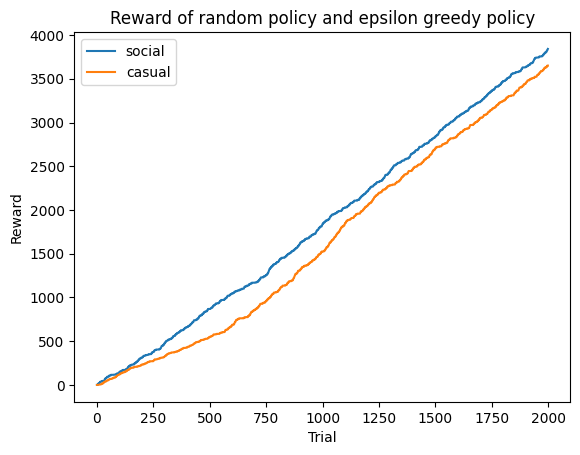

In [206]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(c_rewards_social[:2000], label="social")
ax.plot(c_rewards_casual[:2000], label="casual")

# ax.plot(agents[0].betas, label="beta")
# ax.plot(agents[0].epsilons, label="epsilon")

# Set the title and labels
ax.set_title("Reward of random policy and epsilon greedy policy")
ax.set_xlabel("Trial")
ax.set_ylabel("Reward")
# Show the plot
plt.legend()

plt.savefig("plots/social-mobile.png")

plt.show()